# NLP EXPERIMENTS AND FIGURES

## DESCRIPTION
The objective of this analysis was to study insights about performing cancer survival prediction using unstructured medical text notes. We explore the convenience to use clinical text to show that even applying simple feature transformations to the text like term-frequency inverse document-frequency (TF-IDF), it can be a most accurate way to predict survival than classical stage/grade used in the clinic. It is out of the scope of this study to apply the state of the art for NLP text classification problems. We selected patients with breast, glioma, lung, and prostate cancer. Each cancer type was treated as a separate study but followed the same methodology.

## STATEMENT
 This file is part of <https://github.com/medomics>, a package providing 
 research utility tools for developing precision medicine applications.
 
 --> Copyright (C) 2020  MEDomics consortium

     This package is free software: you can redistribute it and/or modify
     it under the terms of the GNU General Public License as published by
     the Free Software Foundation, either version 3 of the License, or
     (at your option) any later version.

     This package is distributed in the hope that it will be useful,
     but WITHOUT ANY WARRANTY; without even the implied warranty of
     MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
     GNU General Public License for more details.
 
     You should have received a copy of the GNU General Public License
     along with this package.  If not, see <http://www.gnu.org/licenses/>.

## IMPORTS

In [1]:
import re
import os
import pickle
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
warnings.filterwarnings('ignore')

## DEFINE PLOTS

In [3]:
def plot_test(results, disease, period_of_analysis_days=None, ylim = (0,1)):
    """This funtion plot the experiment results."""
    disease_name = ''
    if disease[0] == 'g':
        disease_name = 'Glioma'
        label_stage = 'Stage/Grade'
        surv_label = "predicting 14 months survival"
    elif disease[0] == 'p':
        disease_name = 'Prostate'
        label_stage = 'Stage/Grade'
        surv_label = "predicting 5 years survival"
    elif disease[0] == 'l':
        disease_name = 'Lung'
        label_stage = 'Stage/Grade'
        surv_label = "predicting 2 years survival"
    elif disease[0] == 'b':
        disease_name = 'Breast'
        label_stage = 'Stage/Grade'
        surv_label = "predicting 5 years survival"

    sns.set(style="darkgrid")
    mean_f1_list = []
    mean_f1_s_list = []

    for result_i in results:
        mean_f1_list.append(list(map(lambda x: x[0], result_i['f1'])))
        mean_f1_s_list.append(list(map(lambda x: x[0], result_i['f1_s'])))

    mean_f1 = np.array(mean_f1_list).mean(axis=0)
    std_f1 = np.array(mean_f1_list).std(axis=0)
    mean_f1_s = np.array(mean_f1_s_list).mean(axis=0)
    std_f1_s = np.array(mean_f1_s_list).std(axis=0)

    plt.rcParams.update({'font.size': 20})
    plt.figure(figsize=(10, 5))

    min_xlim = min(20,period_of_analysis_days[0]-10)
    plt.xlim((min_xlim, 380))
    plt.ylim(ylim)
    plt.xlabel("#days of medical text included in the NLP model")
    plt.ylabel("F1 Score")
    plt.title(
        f"{disease_name}: {surv_label} (train {results[0]['n'][-1]}/test {results[0]['n_test'][-1]})")


    xticks_list = sorted(list(set([period_of_analysis_days[0]]+[60, 120, 180, 240, 300, 365])))
    plt.xticks(xticks_list)
    plt.errorbar(period_of_analysis_days, mean_f1, yerr=std_f1, label='NLP')
    plt.errorbar(period_of_analysis_days, mean_f1_s,
                 yerr=std_f1_s, label=label_stage)
    plt.legend(loc='lower right')

    os.makedirs('EPS_experiment', 0o777, True)    
    plt.savefig(
        f'EPS_experiment/{disease}{str(period_of_analysis_days[0])}.eps', format='eps')
    
    # Save data and image in XLSX.
    os.makedirs('XLSX_PNG_experiment', 0o777, True)    
    plt.savefig(
        f'XLSX_PNG_experiment/{disease}{str(period_of_analysis_days[0])}.png', format='png')    

    # Create a Pandas dataframe.    
    results_xlsx = pd.concat([pd.DataFrame(period_of_analysis_days,columns=['days']),
                              pd.DataFrame(mean_f1,columns=['mean_f1_NLP']),
                              pd.DataFrame(std_f1,columns=['std_f1_NLP']),
                              pd.DataFrame(mean_f1_s,columns=['mean_f1_Stage_Grade']),
                              pd.DataFrame(std_f1_s,columns=['std_f1_Stage_Grade'])],axis=1)

    # Create the engine.
    writer = pd.ExcelWriter("XLSX_PNG_experiment/"+disease_name +"_experiment.xlsx", engine='xlsxwriter')

    # Convert the dataframe to an XlsxWriter Excel object.
    sheet_name=f"{disease_name}_start{str(period_of_analysis_days[0])}_size{results[0]['n'][-1]}x{results[0]['n_test'][-1]}"
    results_xlsx.to_excel(writer, sheet_name=sheet_name, index=False)
    workbook  = writer.book
    worksheet = writer.sheets[sheet_name]
    # Insert the png image.
    worksheet.insert_image('I3', f'XLSX_PNG_experiment/{disease}{str(period_of_analysis_days[0])}.png')
    writer.save()
    print(results_xlsx)


def plot_test_stage(results, disease, period_of_analysis_days=None,stage_colname='stage_grade',point = -4):
    """This funtion plot the test set Stage/Grade distribution in one point of
    the experiment."""

    disease_name = ''
    if disease == 'g':
        disease_name = 'Glioma'
    elif disease == 'p':
        disease_name = 'Prostate'
    elif disease == 'l':
        disease_name = 'Lung'
    elif disease == 'b':
        disease_name = 'Breast'

    sns.set(style="darkgrid")
    mean_tfidf_s_list_0_4 = []
    mean_tfidf_s_list_0_3 = []
    mean_tfidf_s_list_0_2 = []
    mean_tfidf_s_list_0_UNK = []
    mean_tfidf_s_list_1_4 = []
    mean_tfidf_s_list_1_3 = []
    mean_tfidf_s_list_1_2 = []
    mean_tfidf_s_list_1_UNK = []
    mean_label_s_list_0_4 = []
    mean_label_s_list_0_3 = []
    mean_label_s_list_0_2 = []
    mean_label_s_list_0_UNK = []
    mean_label_s_list_1_4 = []
    mean_label_s_list_1_3 = []
    mean_label_s_list_1_2 = []
    mean_label_s_list_1_UNK = []

    for results_i in results:
        tfidf_s_list_0_4 = []
        tfidf_s_list_0_3 = []
        tfidf_s_list_0_2 = []
        tfidf_s_list_0_UNK = []
        tfidf_s_list_1_4 = []
        tfidf_s_list_1_3 = []
        tfidf_s_list_1_2 = []
        tfidf_s_list_1_UNK = []
        label_s_list_0_4 = []
        label_s_list_0_3 = []
        label_s_list_0_2 = []
        label_s_list_0_UNK = []
        label_s_list_1_4 = []
        label_s_list_1_3 = []
        label_s_list_1_2 = []
        label_s_list_1_UNK = []
        for test_i in results_i['test']:
            colum_name = [x for x in test_i.columns.tolist()
                          if re.search('_tf_pred', x)][0]
               
            tfidf_s_list_0_4.append(test_i[(test_i[colum_name] == 0) & (
                test_i[stage_colname] == '4')][stage_colname].count())
            tfidf_s_list_0_3.append(test_i[(test_i[colum_name] == 0) & (
                test_i[stage_colname] == '3')][stage_colname].count())
            tfidf_s_list_0_2.append(test_i[(test_i[colum_name] == 0) & (
                (test_i[stage_colname] == '1-2') | (test_i[stage_colname] == '0-2'))][stage_colname].count())
            tfidf_s_list_0_UNK.append(test_i[(test_i[colum_name] == 0) & (
                test_i[stage_colname] == 'UNKNOWN')][stage_colname].count())
            tfidf_s_list_1_4.append(test_i[(test_i[colum_name] == 1) & (
                test_i[stage_colname] == '4')][stage_colname].count())
            tfidf_s_list_1_3.append(test_i[(test_i[colum_name] == 1) & (
                test_i[stage_colname] == '3')][stage_colname].count())
            tfidf_s_list_1_2.append(test_i[(test_i[colum_name] == 1) & (
                (test_i[stage_colname] == '1-2') | (test_i[stage_colname] == '0-2'))][stage_colname].count())
            tfidf_s_list_1_UNK.append(test_i[(test_i[colum_name] == 1) & (
                test_i[stage_colname] == 'UNKNOWN')][stage_colname].count())
            label_s_list_0_4.append(test_i[(test_i['label'] == 0) & (
                test_i[stage_colname] == '4')][stage_colname].count())
            label_s_list_0_3.append(test_i[(test_i['label'] == 0) & (
                test_i[stage_colname] == '3')][stage_colname].count())
            label_s_list_0_2.append(test_i[(test_i['label'] == 0) & (
                (test_i[stage_colname] == '1-2') | (test_i[stage_colname] == '0-2'))][stage_colname].count())
            label_s_list_0_UNK.append(test_i[(test_i['label'] == 0) & (
                test_i[stage_colname] == 'UNKNOWN')][stage_colname].count())
            label_s_list_1_4.append(test_i[(test_i['label'] == 1) & (
                test_i[stage_colname] == '4')][stage_colname].count())
            label_s_list_1_3.append(test_i[(test_i['label'] == 1) & (
                test_i[stage_colname] == '3')][stage_colname].count())
            label_s_list_1_2.append(test_i[(test_i['label'] == 1) & (
                (test_i[stage_colname] == '1-2') | (test_i[stage_colname] == '0-2'))][stage_colname].count())
            label_s_list_1_UNK.append(test_i[(test_i['label'] == 1) & (
                test_i[stage_colname] == 'UNKNOWN')][stage_colname].count())

        mean_tfidf_s_list_0_4.append(list(tfidf_s_list_0_4))
        mean_tfidf_s_list_0_3.append(list(tfidf_s_list_0_3))
        mean_tfidf_s_list_0_2.append(list(tfidf_s_list_0_2))
        mean_tfidf_s_list_0_UNK.append(list(tfidf_s_list_0_UNK))
        mean_tfidf_s_list_1_4.append(list(tfidf_s_list_1_4))
        mean_tfidf_s_list_1_3.append(list(tfidf_s_list_1_3))
        mean_tfidf_s_list_1_2.append(list(tfidf_s_list_1_2))
        mean_tfidf_s_list_1_UNK.append(list(tfidf_s_list_1_UNK))

        mean_label_s_list_0_4.append(list(label_s_list_0_4))
        mean_label_s_list_0_3.append(list(label_s_list_0_3))
        mean_label_s_list_0_2.append(list(label_s_list_0_2))
        mean_label_s_list_0_UNK.append(list(label_s_list_0_UNK))
        mean_label_s_list_1_4.append(list(label_s_list_1_4))
        mean_label_s_list_1_3.append(list(label_s_list_1_3))
        mean_label_s_list_1_2.append(list(label_s_list_1_2))
        mean_label_s_list_1_UNK.append(list(label_s_list_1_UNK))

    mean_tfidf_0_4 = np.array(mean_tfidf_s_list_0_4).mean(axis=0)
    mean_tfidf_0_3 = np.array(mean_tfidf_s_list_0_3).mean(axis=0)
    mean_tfidf_0_2 = np.array(mean_tfidf_s_list_0_2).mean(axis=0)
    mean_tfidf_0_UNK = np.array(mean_tfidf_s_list_0_UNK).mean(axis=0)

    mean_tfidf_1_4 = np.array(mean_tfidf_s_list_1_4).mean(axis=0)
    mean_tfidf_1_3 = np.array(mean_tfidf_s_list_1_3).mean(axis=0)
    mean_tfidf_1_2 = np.array(mean_tfidf_s_list_1_2).mean(axis=0)
    mean_tfidf_1_UNK = np.array(mean_tfidf_s_list_1_UNK).mean(axis=0)

    std_tfidf_0_4 = np.array(mean_tfidf_s_list_0_4).std(axis=0)
    std_tfidf_0_3 = np.array(mean_tfidf_s_list_0_3).std(axis=0)
    std_tfidf_0_2 = np.array(mean_tfidf_s_list_0_2).std(axis=0)
    std_tfidf_0_UNK = np.array(mean_tfidf_s_list_0_UNK).std(axis=0)

    std_tfidf_1_4 = np.array(mean_tfidf_s_list_1_4).std(axis=0)
    std_tfidf_1_3 = np.array(mean_tfidf_s_list_1_3).std(axis=0)
    std_tfidf_1_2 = np.array(mean_tfidf_s_list_1_2).std(axis=0)
    std_tfidf_1_UNK = np.array(mean_tfidf_s_list_1_UNK).std(axis=0)

    mean_label_0_4 = np.array(mean_label_s_list_0_4).mean(axis=0)
    mean_label_0_3 = np.array(mean_label_s_list_0_3).mean(axis=0)
    mean_label_0_2 = np.array(mean_label_s_list_0_2).mean(axis=0)
    mean_label_0_UNK = np.array(mean_label_s_list_0_UNK).mean(axis=0)

    mean_label_1_4 = np.array(mean_label_s_list_1_4).mean(axis=0)
    mean_label_1_3 = np.array(mean_label_s_list_1_3).mean(axis=0)
    mean_label_1_2 = np.array(mean_label_s_list_1_2).mean(axis=0)
    mean_label_1_UNK = np.array(mean_label_s_list_1_UNK).mean(axis=0)

    std_label_0_4 = np.array(mean_label_s_list_0_4).std(axis=0)
    std_label_0_3 = np.array(mean_label_s_list_0_3).std(axis=0)
    std_label_0_2 = np.array(mean_label_s_list_0_2).std(axis=0)
    std_label_0_UNK = np.array(mean_label_s_list_0_UNK).std(axis=0)

    std_label_1_4 = np.array(mean_label_s_list_1_4).std(axis=0)
    std_label_1_3 = np.array(mean_label_s_list_1_3).std(axis=0)
    std_label_1_2 = np.array(mean_label_s_list_1_2).std(axis=0)
    std_label_1_UNK = np.array(mean_label_s_list_1_UNK).std(axis=0)

    labels = ['Non-Survivors', 'Survivors']
    tfidf_4 = np.array([mean_tfidf_0_4[point], mean_tfidf_1_4[point]])
    tfidf_std_4 = np.array([std_tfidf_0_4[point], std_tfidf_1_4[point]])
    tfidf_3 = np.array([mean_tfidf_0_3[point], mean_tfidf_1_3[point]])
    tfidf_std_3 = np.array([std_tfidf_0_3[point], std_tfidf_1_3[point]])
    tfidf_2 = np.array([mean_tfidf_0_2[point], mean_tfidf_1_2[point]])
    tfidf_std_2 = np.array([std_tfidf_0_2[point], std_tfidf_1_2[point]])
    tfidf_UNK = np.array([mean_tfidf_0_UNK[point], mean_tfidf_1_UNK[point]])
    tfidf_std_UNK = np.array([std_tfidf_0_UNK[point], std_tfidf_1_UNK[point]])

    label_4 = np.array([mean_label_0_4[point], mean_label_1_4[point]])
    label_std_4 = np.array([std_label_0_4[point], std_label_1_4[point]])
    label_3 = np.array([mean_label_0_3[point], mean_label_1_3[point]])
    label_std_3 = np.array([std_label_0_3[point], std_label_1_3[point]])
    label_2 = np.array([mean_label_0_2[point], mean_label_1_2[point]])
    label_std_2 = np.array([std_label_0_2[point], std_label_1_2[point]])
    label_UNK = np.array([mean_label_0_UNK[point], mean_label_1_UNK[point]])
    label_std_UNK = np.array([std_label_0_UNK[point], std_label_1_UNK[point]])

    N = 2
    ind = np.arange(N)    # the x locations for the groups
    width = 0.35          # the width of the bars

    plt.figure(figsize=(5, 5))
    p1 = plt.bar(ind - width/2, tfidf_4, width, yerr=tfidf_std_4, color='blue')
    
    p2 = plt.bar(ind - width/2, tfidf_3, width,
                 bottom=tfidf_4, yerr=tfidf_std_3, color='red')
    p3 = plt.bar(ind - width/2, tfidf_2, width, bottom=tfidf_4 +
                 tfidf_3, yerr=tfidf_std_2, color='orange')
    p4 = plt.bar(ind - width/2, tfidf_UNK, width, bottom=tfidf_4 +
                 tfidf_3+tfidf_2, yerr=tfidf_std_UNK, color='green')


    p1 = plt.bar(ind + width/2, label_4, width, yerr=label_std_4, color='blue')
    p2 = plt.bar(ind + width/2, label_3, width,
                 bottom=label_4, yerr=label_std_3, color='red')
    p3 = plt.bar(ind + width/2, label_2, width, bottom=label_4 +
                 label_3, yerr=label_std_2, color='orange')
    p4 = plt.bar(ind + width/2, label_UNK, width, bottom=label_4 +
                 label_3+label_2, yerr=label_std_UNK, color='green')

    xy=((ind[0] - width*(3/4) ), (tfidf_4[0] + tfidf_3[0] + tfidf_2[0] + tfidf_UNK[0] + 1.5))
    plt.annotate("NLP",xy=xy)
    
    xy=((ind[1] - width*(3/4) ), (tfidf_4[1] + tfidf_3[1] + tfidf_2[1] + tfidf_UNK[1] + 1.5))
    plt.annotate("NLP",xy=xy)
    
    xy=((ind[0] + width*(1/10) ), (label_4[0] + label_3[0] + label_2[0] + label_UNK[0] + 1.5))
    plt.annotate("G-Truth",xy=xy)
    
    xy=((ind[1] + width*(1/10) ), (label_4[1] + label_3[1] + label_2[1] + label_UNK[1] + 1.5))
    plt.annotate("G-Truth",xy=xy)

    plt.ylabel('#Patients')
    plt.xticks(ind, labels)


    plt.title(
        f"{disease_name}: Stage/Grade distribution {period_of_analysis_days[point]} days (test {results[0]['n_test'][-1]})")

    
        
    plt.legend((p1[0], p2[0], p3[0], p4[0]), ('4', '3', 'Low', 'Unk'))
       
    os.makedirs('EPS_stage', 0o777, True)    
    plt.savefig(
        f'EPS_stage/{disease}{period_of_analysis_days[0]}-days{period_of_analysis_days[point]}-stage.eps', format='eps')

    # Save data and image in XLSX.
    os.makedirs('XLSX_PNG_stage', 0o777, True)    
    plt.savefig(
        f'XLSX_PNG_stage/{disease}{period_of_analysis_days[0]}-days{period_of_analysis_days[point]}-stage.png', format='png')    

    # Create a Pandas dataframe.    

    arrays = [np.array(['4', '4', '3', '3', 'Low', 'Low', 'Unk', 'Unk']),
              np.array(['mean', 'std', 'mean', 'std', 'mean', 'std', 'mean', 'std'])]
    arrays_col = [np.array(['Non-Survivors', 'Non-Survivors', 'Survivors', 'Survivors']),
                  np.array(['NLP', 'G-Truth', 'NLP', 'G-Truth'])]

    all_values = np.array([[  mean_tfidf_0_4[point],    mean_label_0_4[point],    mean_tfidf_1_4[point],    mean_label_1_4[point]],
                           [   std_tfidf_0_4[point],     std_label_0_4[point],     std_tfidf_1_4[point],     std_label_1_4[point]],
                           [  mean_tfidf_0_3[point],    mean_label_0_3[point],    mean_tfidf_1_3[point],    mean_label_1_3[point]],
                           [   std_tfidf_0_3[point],     std_label_0_3[point],     std_tfidf_1_3[point],     std_label_1_3[point]],
                           [  mean_tfidf_0_2[point],    mean_label_0_2[point],    mean_tfidf_1_2[point],    mean_label_1_2[point]],
                           [   std_tfidf_0_2[point],     std_label_0_2[point],     std_tfidf_1_2[point],     std_label_1_2[point]],
                           [mean_tfidf_0_UNK[point],  mean_label_0_UNK[point],  mean_tfidf_1_UNK[point],  mean_label_1_UNK[point]],
                           [ std_tfidf_0_UNK[point],   std_label_0_UNK[point],   std_tfidf_1_UNK[point],   std_label_1_UNK[point]]])
    
    results_xlsx = pd.DataFrame(all_values, index=arrays, columns=arrays_col)

   
    # Create the engine.
    writer = pd.ExcelWriter("XLSX_PNG_stage/"+disease_name +"_stage.xlsx", engine='xlsxwriter')

    # Convert the dataframe to an XlsxWriter Excel object.
    sheet_name=f"{disease_name}_start{str(period_of_analysis_days[0])}_size{results[0]['n'][-1]}x{results[0]['n_test'][-1]}"
    results_xlsx.to_excel(writer, sheet_name=sheet_name, index=True)
    workbook  = writer.book
    worksheet = writer.sheets[sheet_name]
    # Insert the png image.
    worksheet.insert_image('I3', f'XLSX_PNG_stage/{disease}{period_of_analysis_days[0]}-days{period_of_analysis_days[point]}-stage.png')
    writer.save()
    print(results_xlsx)
                        

## PLOT RESULTS

In [5]:
# List of pickle names for each experiment with the time series used.

list_of_pickle_names = [['glioma30', [30, 60, 120, 180, 240, 300, 365]],
                        ['breast30', [30, 60, 120, 180, 240, 300, 365]],
                        ['lung30', [30, 60, 120, 180, 240, 300, 365]],
                        ['prostate60', [60, 120, 180, 240, 300, 365]]]


glioma30


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


   days  mean_f1_NLP  std_f1_NLP  mean_f1_Stage_Grade  std_f1_Stage_Grade
0    30     0.622789    0.040910             0.513395        3.401215e-03
1    60     0.669565    0.040177             0.514155        1.110223e-16
2   120     0.702512    0.040502             0.514155        1.110223e-16
3   180     0.714786    0.045863             0.514155        1.110223e-16
4   240     0.734179    0.034676             0.514155        1.110223e-16
5   300     0.745401    0.042546             0.514155        1.110223e-16
6   365     0.764541    0.038242             0.514155        1.110223e-16
breast30


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


   days  mean_f1_NLP  std_f1_NLP  mean_f1_Stage_Grade  std_f1_Stage_Grade
0    30     0.758564    0.049495             0.675336            0.012126
1    60     0.773756    0.033913             0.672741            0.008902
2   120     0.788265    0.028948             0.672741            0.008902
3   180     0.796205    0.030616             0.672741            0.008902
4   240     0.814421    0.025108             0.672741            0.008902
5   300     0.818163    0.038327             0.672741            0.008902
6   365     0.820758    0.031681             0.672741            0.008902
lung30


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


   days  mean_f1_NLP  std_f1_NLP  mean_f1_Stage_Grade  std_f1_Stage_Grade
0    30     0.762012    0.027459             0.748024        1.110223e-16
1    60     0.769363    0.030089             0.748024        1.110223e-16
2   120     0.778612    0.026655             0.748024        1.110223e-16
3   180     0.813992    0.033968             0.748024        1.110223e-16
4   240     0.815798    0.033146             0.748024        1.110223e-16
5   300     0.812776    0.026954             0.748024        1.110223e-16
6   365     0.818847    0.024353             0.748024        1.110223e-16
prostate60


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


   days  mean_f1_NLP  std_f1_NLP  mean_f1_Stage_Grade  std_f1_Stage_Grade
0    60     0.813190    0.033835             0.807531            0.018135
1   120     0.839935    0.026678             0.804589            0.021619
2   180     0.828478    0.035819             0.804589            0.021619
3   240     0.829839    0.037717             0.804589            0.021619
4   300     0.826879    0.037951             0.804589            0.021619
5   365     0.833314    0.037748             0.804589            0.021619


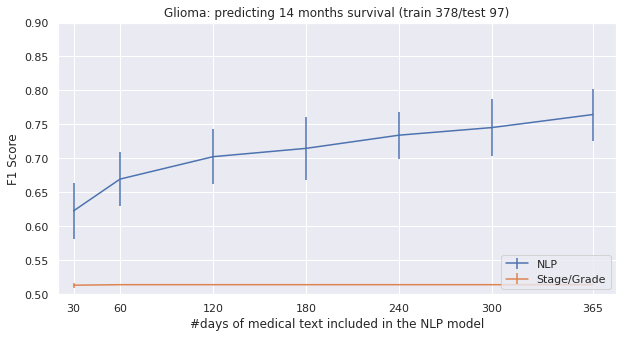

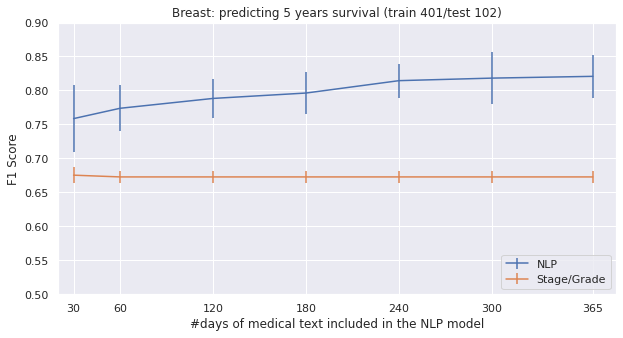

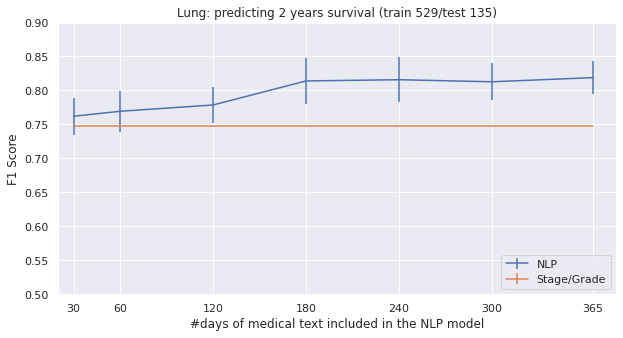

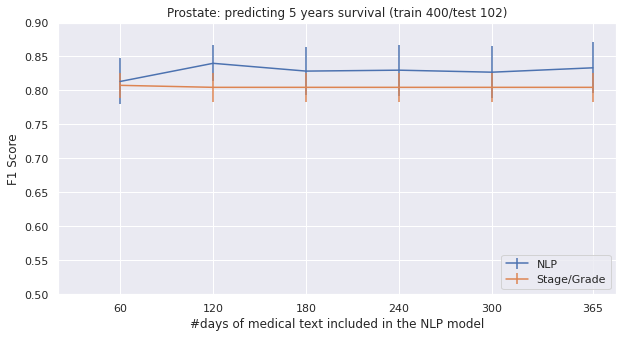

In [6]:
# Plots of time series experiments
PATH = ''
SUFFIX = ''

for name in list_of_pickle_names:
    with open(PATH+name[0]+SUFFIX+'.pickle', 'rb') as f:    
        print(name[0]+SUFFIX)
        results_list = pickle.load(f)
        plot_test(results_list, name[0][:1], name[1],(0.5,0.9))


glioma30


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


         Non-Survivors          Survivors        
                   NLP G-Truth        NLP G-Truth
4   mean     30.809524    33.0  44.190476    42.0
    std       4.972487     0.0   4.972487     0.0
3   mean      3.619048     3.0  15.380952    16.0
    std       0.949997     0.0   0.949997     0.0
Low mean      0.380952     1.0   2.619048     2.0
    std       0.485621     0.0   0.485621     0.0
Unk mean      0.000000     0.0   0.000000     0.0
    std       0.000000     0.0   0.000000     0.0
breast30


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


         Non-Survivors             Survivors           
                   NLP    G-Truth        NLP    G-Truth
4   mean      8.476190   7.476190   1.523810   2.523810
    std       0.731538   0.499433   0.731538   0.499433
3   mean      3.333333   4.000000   7.666667   7.000000
    std       1.038925   0.000000   1.038925   0.000000
Low mean      6.095238  10.000000  68.904762  65.000000
    std       1.924894   0.000000   1.924894   0.000000
Unk mean      1.142857   1.000000   4.857143   5.000000
    std       0.773718   0.000000   0.773718   0.000000
lung30


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


         Non-Survivors          Survivors        
                   NLP G-Truth        NLP G-Truth
4   mean     45.285714    41.0  10.714286    15.0
    std       3.282607     0.0   3.282607     0.0
3   mean     12.000000    11.0   7.000000     8.0
    std       2.023669     0.0   2.023669     0.0
Low mean      6.142857    10.0  44.857143    41.0
    std       2.122122     0.0   2.122122     0.0
Unk mean      1.523810     1.0   7.476190     8.0
    std       0.851835     0.0   0.851835     0.0
prostate60


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


         Non-Survivors          Survivors        
                   NLP G-Truth        NLP G-Truth
4   mean     10.238095    10.0   0.761905     1.0
    std       0.683462     0.0   0.683462     0.0
3   mean      1.571429     2.0   9.428571     9.0
    std       0.954759     0.0   0.954759     0.0
Low mean      5.380952     7.0  68.619048    67.0
    std       1.863846     0.0   1.863846     0.0
Unk mean      4.571429     4.0   1.428571     2.0
    std       1.094202     0.0   1.094202     0.0


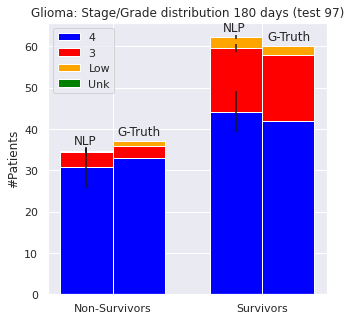

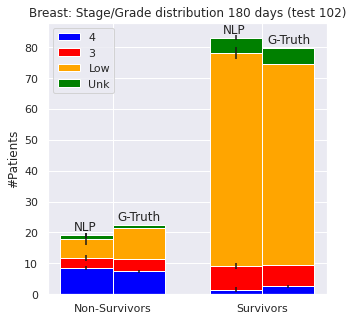

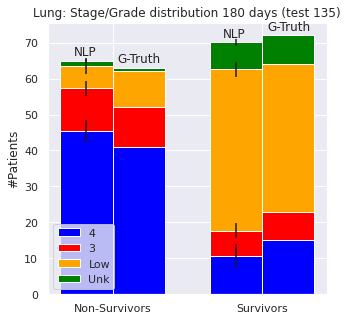

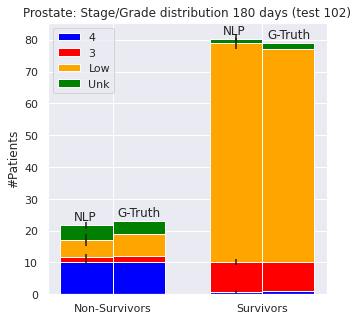

In [7]:
# Test set stage distribution in one point of the experiment.

for name in list_of_pickle_names:
    with open(PATH+name[0]+SUFFIX+'.pickle', 'rb') as f:
        print(name[0]+SUFFIX)
        results_list = pickle.load(f)
        plot_test_stage(results_list, name[0][:1], name[1],point = -4)
